In [1]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
class KITTI(object):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(path, "training/image_2"))))
        self.lbls = list(sorted(os.listdir(os.path.join(path, "training/label_2"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, "training/image_2", self.imgs[idx])
        lbl_path = os.path.join(self.path, "training/label_2", self.lbls[idx])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        num_objs = 0
        for i in open(lbl_path).readlines():
          i = i.split()
          labels.append(KITTI_CLASSES.index(i[0]))
          boxes.append(list(map(float,i[4:8])))
          num_objs += 1
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
dataset = KITTI('/drive/My Drive/KITTI', get_transform(train=True))
dataset_test = KITTI('/drive/My Drive/KITTI', get_transform(train=False))

KITTI_CLASSES= [
    'BG','Car','Van','Truck',
    'Pedestrian','Person_sitting',
    'Cyclist','Tram','Misc','DontCare'
    ]

num_classes = len(KITTI_CLASSES)

In [0]:
def draw_box(box, label, score=''):
    x1, y1, x2, y2 = box
    color = plt.cm.get_cmap('tab10')(label)
    rect = Rectangle((x1,y1),x2-x1,y2-y1,linewidth=2,
                     edgecolor='k',
                     facecolor=color,alpha=0.5)
    plt.gca().add_patch(rect)
    label = KITTI_CLASSES[label] + ' : ' + score if score else KITTI_CLASSES[label]
    plt.text(x1, y2, label, color='w')

def plot_img(image, target=None, thld=0.5):
    image = image.permute(1,2,0).numpy()
    plt.imshow(image)
    if target:
        for i in range(len(target['labels'])):
            scores = target.get('scores')
            if scores is not None:
                if scores[i]<thld:
                    continue
                draw_box(target['boxes'][i], int(target['labels'][i]), str(float(scores[i]))[:4])
            else:
                draw_box(target['boxes'][i], int(target['labels'][i]))       
   

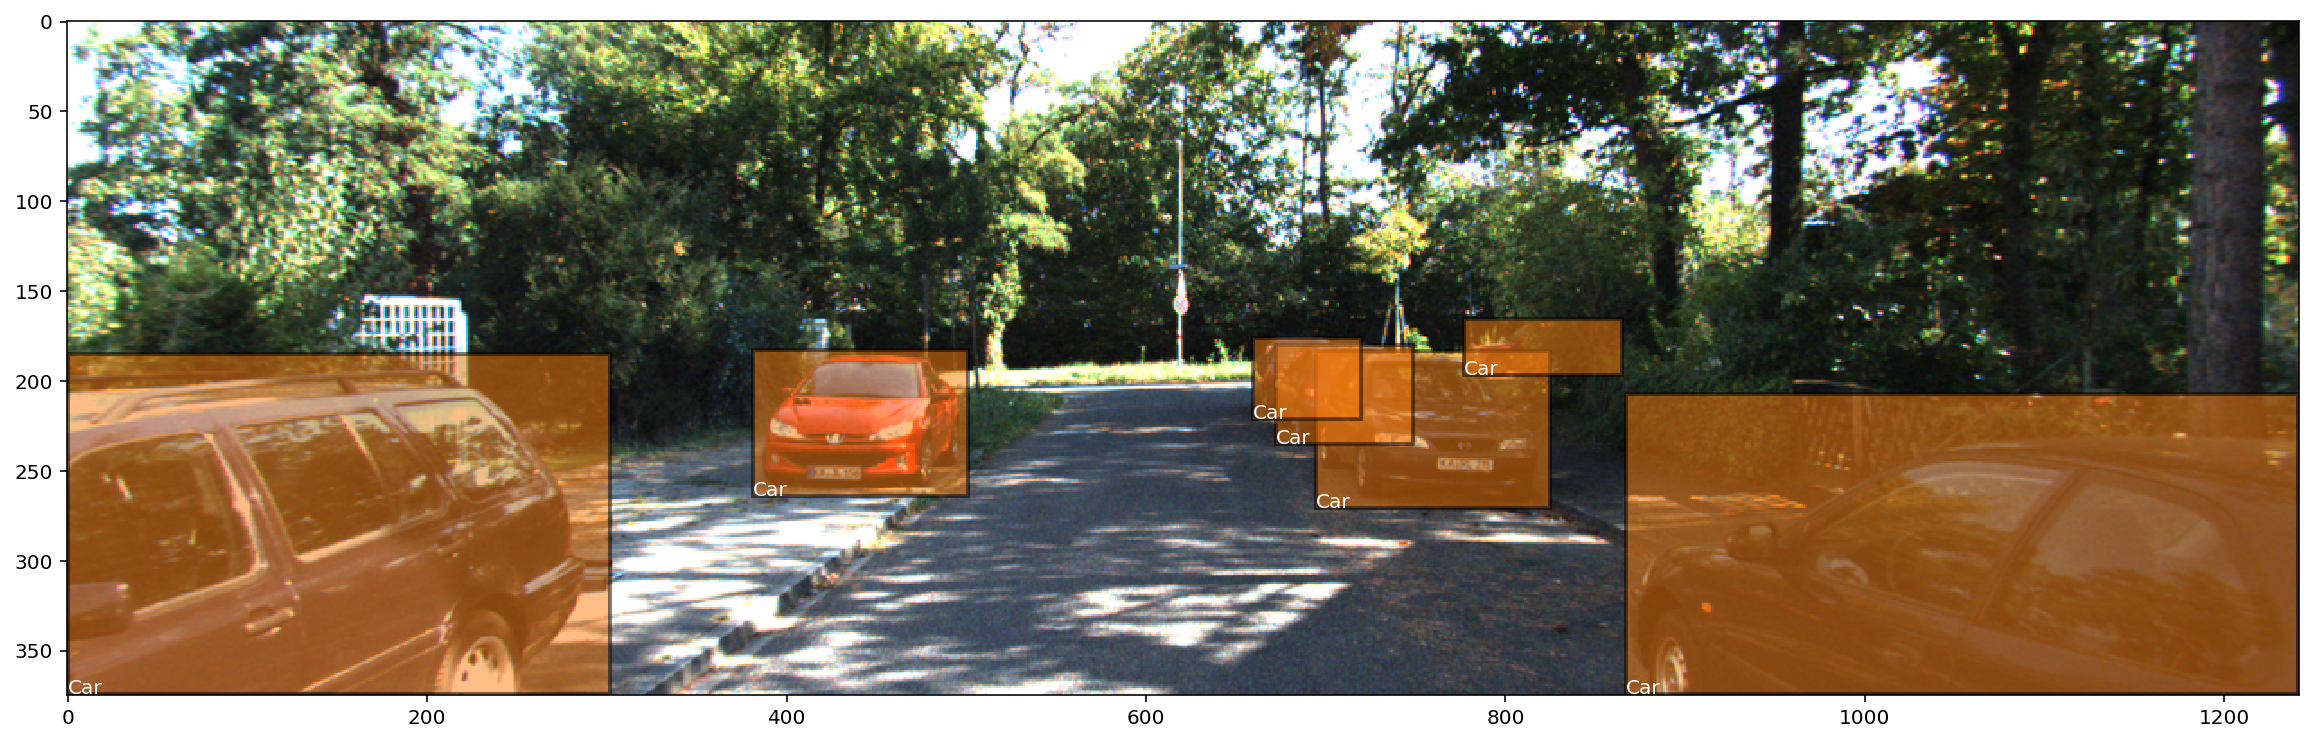

In [39]:
img, trgt = dataset_test[2]
plt.figure(figsize=(20,20))
plot_img(img, trgt)

In [0]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
 
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [13]:
num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1858]  eta: 1:15:19  lr: 0.000010  loss: 3.1015 (3.1015)  loss_classifier: 2.2539 (2.2539)  loss_box_reg: 0.0835 (0.0835)  loss_objectness: 0.7069 (0.7069)  loss_rpn_box_reg: 0.0572 (0.0572)  time: 2.4326  data: 0.8901  max mem: 3913
Epoch: [0]  [ 100/1858]  eta: 0:24:36  lr: 0.000509  loss: 0.4942 (1.1724)  loss_classifier: 0.1839 (0.6114)  loss_box_reg: 0.0606 (0.0452)  loss_objectness: 0.2318 (0.4669)  loss_rpn_box_reg: 0.0357 (0.0489)  time: 0.8259  data: 0.0111  max mem: 4538
Epoch: [0]  [ 200/1858]  eta: 0:23:06  lr: 0.001009  loss: 0.3265 (0.7972)  loss_classifier: 0.1450 (0.3959)  loss_box_reg: 0.0482 (0.0536)  loss_objectness: 0.1039 (0.3041)  loss_rpn_box_reg: 0.0284 (0.0436)  time: 0.8377  data: 0.0109  max mem: 4538
Epoch: [0]  [ 300/1858]  eta: 0:21:43  lr: 0.001508  loss: 0.3998 (0.6690)  loss_classifier: 0.1826 (0.3275)  loss_box_reg: 0.0913 (0.0614)  loss_objectness: 0.1057 (0.2393)  loss_rpn_box_reg: 0.0379 (0.0408)  time: 0.8331  data: 0.0111  max me

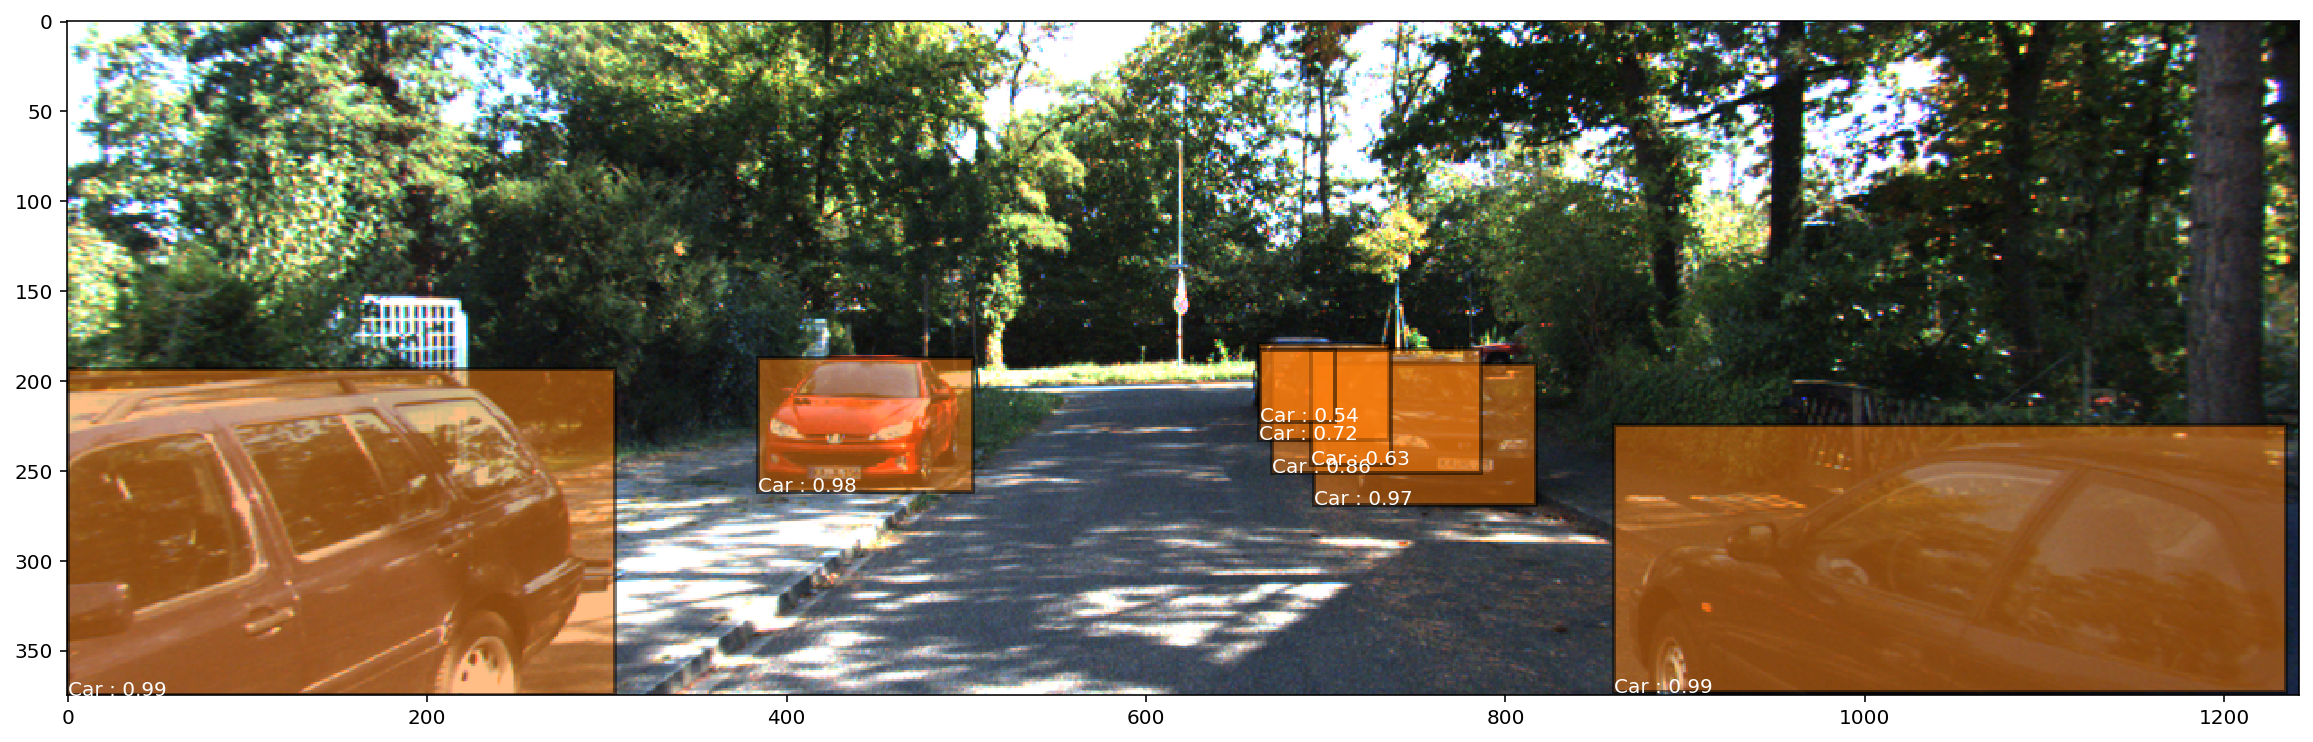

In [38]:
img, _ = dataset_test[2]
model.eval()
with torch.no_grad():
    pred = model([img.to(device)])
plt.figure(figsize=(20,20))
plot_img(img, pred[0])